In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib

import common.loss_utils as loss_utils

import sys
sys.path.append('./dgmr_original')
import dgmr


/home/sigaida/miniconda3/envs/chtest/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16

In [5]:
p = pathlib.Path('data/data_random_300.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [6]:
times.shape, data.shape

((18354,), (18354, 325, 400))

In [7]:
_MEAN_PIXEL = 240.3414
_STD_PIXEL = 146.52366

torch.manual_seed(7)
tsfm = transforms.Compose([
    transforms.Normalize(_MEAN_PIXEL, _STD_PIXEL),
])

In [8]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, tsfm, shuffle=True, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)
        self.indices = np.arange(len(self.times) - 35)
        self.tsfm = tsfm
        if shuffle:
            self.generator.shuffle(self.indices)
        self.index_to_randx = [self.generator.randint(0, data.shape[2] - 128) for _ in range(len(self.indices))]
        self.index_to_randy = [self.generator.randint(0, data.shape[1] - 128) for _ in range(len(self.indices))]

    def _get_crop(self, index, data):
        # roughly over the mainland UK
        # going determinstic for repeatable experiments
        rand_x = self.index_to_randx[index] # self.generator.randint(0, input_slice.shape[2] - 128)
        rand_y = self.index_to_randy[index] # self.generator.randint(0, input_slice.shape[1] - 128)
        
        # make a data selection
        return data[:, rand_y : rand_y + 128, rand_x : rand_x + 128]

    def __getitem__(self, i):
        index = self.indices[i]
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((i + 35) % len(self))
        all_data = self.data[index:index+INPUT_STEPS+24]
        all_data = self._get_crop(index, all_data)
        all_data = torch.FloatTensor(all_data)
        all_data = self.tsfm(all_data)
        x = all_data[:INPUT_STEPS]
        y = all_data[INPUT_STEPS:]
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data, tsfm)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4
)


In [9]:
x, y = ds[0]

In [10]:
x.shape, y.shape

(torch.Size([4, 128, 128]), torch.Size([24, 128, 128]))

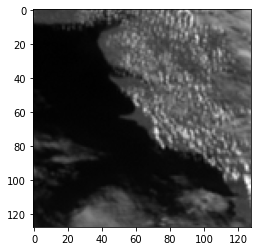

In [11]:
plt.imshow(x[-1], cmap='gray')

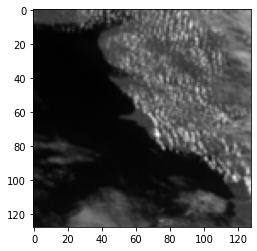

In [12]:
plt.imshow(y[0], cmap='gray')

In [13]:
ccs = dgmr.common.ContextConditioningStack(
    input_channels=1,
    conv_type='standard',
    output_channels=192,
)

lcs = dgmr.common.LatentConditioningStack(
    shape=(8 * 1, 128 // 32, 128 // 32),
    output_channels=384,
)

sampler = dgmr.generators.Sampler(
    forecast_steps=FORECAST,
    latent_channels=384,
    context_channels=192,
)

model = dgmr.generators.Generator(ccs, lcs, sampler)
model.load_state_dict(torch.load('weights/dgmr_full_128_msssim_notransform/dgmr_epochs=300_loss=0.2085.pt'))
model = model.to(DEVICE)


In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 13399657 trainable parameters


In [59]:
def get_mssim(y, x, average=True):
    assert len(y.shape) == 5
    if average:
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=y.shape[1])
        return criterion(y, x)
    else:
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=False, win_size=3, channel=1)
        b, t, c, h, w = y.shape
        y = y.reshape(b*t, 1, c, h , w)
        x = x.reshape(b*t, 1, c, h, w)
        score = criterion(y, x)
        return score.reshape(b, t)

In [108]:
model.train()
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=24)
final_layer = torch.nn.AvgPool2d(kernel_size=2)

scores = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl)

LOOKS = 63
all_preds = []
for i, (srcs, trgs) in enumerate(pbar):
    x = srcs.to(DEVICE)
    y = trgs.to(DEVICE)
    if i > LOOKS:
        break
    # add a dimension because 1D image
    x = torch.unsqueeze(x, dim=2)
    y = torch.unsqueeze(y, dim=2)
    
    with torch.no_grad():
        preds = model(x)
    
    y = y * _STD_PIXEL + _MEAN_PIXEL
    preds = preds * _STD_PIXEL + _MEAN_PIXEL
#     preds[preds > 1023] = 1023
#     preds[preds < 0] = 0
    all_preds.append(np.squeeze(preds.detach().cpu().numpy()))

    score = get_mssim(preds[:,:,:,32:96,32:96], y[:,:,:,32:96,32:96], average=False)
    score = score.detach().cpu().numpy()
    scores.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')

    

Avg Score: 0.792479689233005:   6%|▌         | 64/1145 [00:25<07:04,  2.55it/s] 


In [109]:
all_preds = np.concatenate(all_preds, axis=0)
scores = np.concatenate(scores, axis=0)

In [110]:
all_preds.shape, scores.shape

((1024, 24, 128, 128), (1024, 24))

In [111]:
x, y = ds[2]

In [112]:
x.shape, y.shape

(torch.Size([4, 128, 128]), torch.Size([24, 128, 128]))

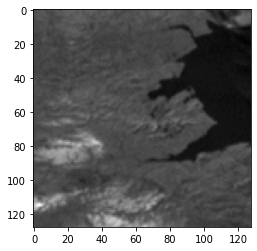

In [113]:
plt.imshow(x[-1], cmap='gray')

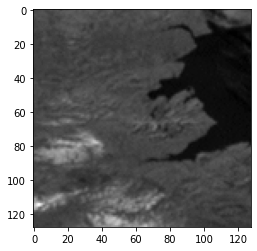

In [114]:
plt.imshow(y[0], cmap='gray')

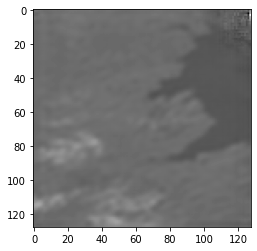

In [115]:
plt.imshow(all_preds[2,0], cmap='gray')

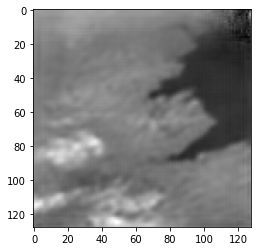

In [122]:
plt.imshow(all_preds[2,-1], cmap='gray')

In [116]:
scores[2]

array([0.99770916, 0.9975932 , 0.9973639 , 0.9965987 , 0.99633145,
       0.9957304 , 0.99415565, 0.9909993 , 0.98790634, 0.9850596 ,
       0.98206955, 0.98011106, 0.97952133, 0.98116744, 0.9850211 ,
       0.9870639 , 0.98398703, 0.9768203 , 0.9718646 , 0.9674491 ,
       0.96706307, 0.97163564, 0.9767016 , 0.98273623], dtype=float32)

In [117]:
mask = np.load('mask.npy')

In [118]:
easy = scores[mask]

In [120]:
easy.shape

(195, 24)

In [119]:
np.mean(easy, axis=0)

array([0.9856525 , 0.9764009 , 0.9683347 , 0.9607886 , 0.95418054,
       0.94852626, 0.9449103 , 0.940899  , 0.93772936, 0.9348038 ,
       0.9333342 , 0.93280333, 0.93189   , 0.93014675, 0.92970324,
       0.928417  , 0.92815393, 0.92729056, 0.926061  , 0.92559457,
       0.9255842 , 0.9266765 , 0.92541623, 0.9248547 ], dtype=float32)

In [97]:
plt.rc('animation', html='jshtml')
from matplotlib import animation

def get_mssim(y, x):
    if len(y.shape) == 2:
        # we need to specify a number of channels. This sets it to 1 and calls the function again
        return get_mssim(np.expand_dims(y, 0), np.expand_dims(x, 0))
    if len(y.shape) == 4:
        y = y.reshape(-1, y.shape[2], y.shape[3])
        x = x.reshape(-1, x.shape[2], x.shape[3])
    assert len(y.shape) == 3
    mssim_loss = loss_utils.MS_SSIMLoss(data_range=1023, channels=y.shape[0])
    yd = np.expand_dims(y, 0) # /255 * (MAX - MIN) + MIN
    xd = np.expand_dims(x, 0) # /255 * (MAX - MIN) + MIN
    return 1.0 - mssim_loss(
        torch.Tensor(yd),
        torch.Tensor(xd),
    ).item()

def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:, :, 0] += np.arange(w)
    flow[:, :, 1] += np.arange(h)[:, np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return res

def plot_animation(input_images, images, dgmr_images):
    fig, (ax_true, ax_dgmr) = plt.subplots(1, 2, figsize=(10,10))
    plt.close() # Prevents extra axes being plotted below animation

    img_true = ax_true.imshow(images[0], cmap='gray')
    img_dgmr = ax_dgmr.imshow(dgmr_images[0], cmap='gray')

    def animate(i):
        nonlocal images, dgmr_images
        ref = images[i, 32:96, 32:96]
        pers_score = get_mssim(input_images[-1, 32:96,32:96], ref)
        dgmr_score = get_mssim(dgmr_images[i, 32:96,32:96], ref)
        ax_true.title.set_text(f'Step {i} Persistence MS-SSIM: {pers_score}')
        ax_dgmr.title.set_text(f'Step {i} DGMR MS-SSIM: {dgmr_score}')
        return img_true.set_data(images[i]), img_dgmr.set_data(dgmr_images[i])

    return animation.FuncAnimation(fig, animate, frames=images.shape[0], interval=1000, blit=False)


In [101]:
idx = 0
x, y = ds[idx]
x = x * _STD_PIXEL + _MEAN_PIXEL
y = y * _STD_PIXEL + _MEAN_PIXEL
plot_animation(x, y, all_preds[idx])